In [1]:
!git clone https://github.com/LukeV37/ML_Tutorial_2025.git

Cloning into 'ML_Tutorial_2025'...
remote: Enumerating objects: 95, done.
remote: Counting objects: 100% (95/95), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 95 (delta 40), reused 73 (delta 22), pack-reused 0 (from 0)
Receiving objects: 100% (95/95), 1.47 MiB | 11.67 MiB/s, done.
Resolving deltas: 100% (40/40), done.
Filtering content: 100% (3/3), 1.12 GiB | 46.10 MiB/s, done.


In [2]:
%cd ML_Tutorial_2025/software
!curl -O https://www.pythia.org/download/pythia83/pythia8312.tgz
!tar xfz pythia8312.tgz
%cd pythia8312
!./configure --with-python-config=/usr/bin/python3.11-config
!make -j4
%cd ../../notebooks
!pip install awkward

/content/ML_Tutorial_2025/software
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28.8M  100 28.8M    0     0  12.1M      0  0:00:02  0:00:02 --:--:-- 12.1M
/content/ML_Tutorial_2025/software/pythia8312
Running PYTHIA configuration script. Now is Tue Jul 1 05:22:25 PM UTC 2025
---------------------------------------------------------------------
|                    PYTHIA Configuration Summary                   |
---------------------------------------------------------------------
  Architecture                = LINUX
  C++ compiler     CXX        = g++
  C++ dynamic tags CXX_DTAGS  = -Wl,--disable-new-dtags
  C++ flags        CXX_COMMON = -O2 -std=c++11 -pedantic -W -Wall -Wshadow -fPIC -pthread
  C++ shared flag  CXX_SHARED = -shared
  Further options             = 

The following optional external packages will be used:
 + PYTHON (-I/usr/include/python3.11 -I/usr/incl

In [3]:
# Add the necessary pythia build paths to the python paths
import sys
cfg = open("../software/pythia8312/Makefile.inc")  # Read necessary paths from this file
lib = "../software/lib"
for line in cfg:
    if line.startswith("PREFIX_LIB="): lib = line[11:-1]; break  # Find build paths
sys.path.insert(0, lib)   # Add build paths to system path

In [4]:
# Import Pythia8
import pythia8

# Import Tensor Libs
import numpy as np
import awkward as ak

# Import ML Libs
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Import Plotting Libs
import matplotlib.pyplot as plt

In [5]:
pythia_sig = pythia8.Pythia()                  # Define a pythia8.Pythia() object
pythia_sig.readString("Beams:eCM = 14000.")    # Beam energy is 14TeV
pythia_sig.readString("Beams:idA = 2212")      # Incoming particle 1 is proton
pythia_sig.readString("Beams:idB = 2212")      # Incoming particle 2 is proton
pythia_sig.readString("Top:qqbar2ttbar = on")  # Turn on all top processes
pythia_sig.init()                              # Initialize object with user defined settings

True

In [6]:
pythia_bkg = pythia8.Pythia()                  # Define a pythia8.Pythia() object
pythia_bkg.readString("Beams:eCM = 14000.")    # Beam enegery is 14TeV
pythia_bkg.readString("Beams:idA = 2212")      # Incoming particle 1 is proton
pythia_bkg.readString("Beams:idB = 2212")      # Incoming particle 2 is proton
pythia_bkg.readString("WeakDoubleBoson:ffbar2WW = on")      # Turn on all Diboson process
pythia_bkg.init()                              # Initialize object with user defined settings

True

In [7]:
num_events = 1000

In [8]:
# Begin event loop. Generate event. Skip if error.
sig_events = []
for iEvent in range(num_events):           # Loop through events
    event_sig = []
    if iEvent%5==0:
        print("Generating Signal: ", iEvent, " / ", num_events, end="\r")
    if not pythia_sig.next(): continue     # Standard pythia syntax to trigger next event generation
    for prt in pythia_sig.event:           # Loop through particles in each event
        if prt.isFinal():                  # Check if particle is final state particle and store pT, eta, phi
            event_sig.append([prt.pT(),prt.eta(),prt.phi()])
    sig_events.append(event_sig)
print("Done Generating Signal: ", num_events, " / ", num_events)

print("Converting to Awkward Array...")
sig_events = ak.Array(sig_events)
print("Done Converting to Awkward Array")

Done Generating Signal:  1000  /  1000
Converting to Awkward Array...
Done Converting to Awkward Array


In [9]:
# Begin event loop. Generate event. Skip if error.
bkg_events = []
for iEvent in range(num_events):          # Loop through events
    event_bkg = []
    if iEvent%5==0:
        print("Generating Background: ", iEvent, " / ", num_events, end="\r")
    if not pythia_bkg.next(): continue    # Standard pythia syntax to trigger enxt event generation
    for prt in pythia_bkg.event:          # Loop through particles in each event
        if prt.isFinal():                 # Chekc if particle is final stat particle and store pT, eta, phi
            event_bkg.append([prt.pT(),prt.eta(),prt.phi()])
    bkg_events.append(event_bkg)
print("Done Generating Background: ", num_events, " / ", num_events)

print("Converting to Awkward Array...")
bkg_events = ak.Array(bkg_events)
print("Done Converting to Awkward Array")

Done Generating Background:  1000  /  1000
Converting to Awkward Array...
Done Converting to Awkward Array


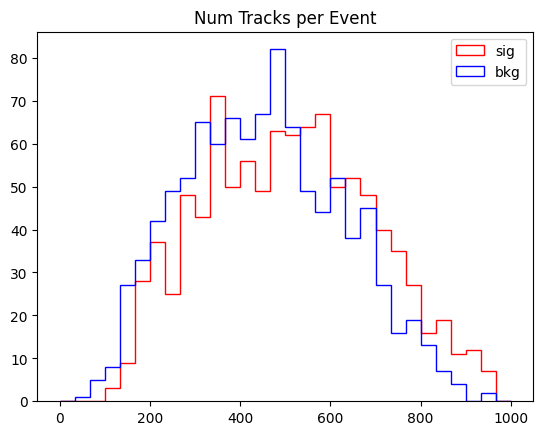

In [10]:
plt.title("Num FS Particles per Event")
plt.hist(ak.num(sig_events),histtype='step',color='r',range=(0,1000),bins=30,label='sig')
plt.hist(ak.num(bkg_events),histtype='step',color='b',range=(0,1000),bins=30,label='bkg')
plt.legend()
plt.show()

In [ ]:
# Plot pT for signal and background
plt.title("Particle p$\mathregular{_{T}}$")
plt.hist(ak.ravel(sig_events[:,:,0]),bins=40,range=(0,250),histtype='step',label='sig',color='r',density=True)
plt.hist(ak.ravel(bkg_events[:,:,0]),bins=40,range=(0,250),histtype='step',label='bkg',color='b',density=True)
plt.xlabel('GeV',loc='right')
plt.yscale('log')
plt.legend()
plt.show()

# Plot eta for signal and background
plt.title("Particle \u03B7")
plt.hist(ak.ravel(sig_events[:,:,1]),bins=30,range=(-10,10),histtype='step',label='sig',color='r',density=True)
plt.hist(ak.ravel(bkg_events[:,:,1]),bins=30,range=(-10,10),histtype='step',label='bkg',color='b',density=True)
plt.legend()
plt.show()

# Plot phi for signal and background
plt.title("Particle \u03D5")
plt.hist(ak.ravel(sig_events[:,:,2]),bins=16,range=(-4,4),histtype='step',label='sig',color='r',density=True)
plt.hist(ak.ravel(bkg_events[:,:,2]),bins=16,range=(-4,4),histtype='step',label='bkg',color='b',density=True)
plt.legend()
plt.show()

In [ ]:
sorted_args = ak.argsort(sig_events[:,:,0], ascending=False)
sorted_sig = sig_events[sorted_args]
sig_labels = np.ones((len(sorted_sig),1))

sorted_args = ak.argsort(bkg_events[:,:,0], ascending=False)
sorted_bkg = bkg_events[sorted_args]
bkg_labels = np.zeros((len(sorted_bkg),1))

combined_data = ak.concatenate([sorted_sig,sorted_bkg], axis=0)
combined_labels = ak.concatenate([sig_labels,bkg_labels], axis=0)

p = np.random.permutation(len(combined_data))
combined_data = combined_data[p]
combined_labels = combined_labels[p]

In [ ]:
padding_particle_cutoff = 100

In [ ]:
padded_data = []
for i, event in enumerate(combined_data):
    if i%5==0:
        print("Padding Dataset: ", i, " / ", len(combined_data), end="\r")
    event_data = []
    for j in range(padding_particle_cutoff):
        if j<len(event):
            event_data.append(event[j])
        else:
            event_data.append([0,0,0])
    padded_data.append(event_data)
print("Done Padding Dataset: ", len(combined_data), " / ", len(combined_data))

print("Converting to Awkward Array...")
padded_data = ak.Array(padded_data)
print("Done Converting to Awkward Array")

In [ ]:
sig = combined_labels==1
bkg = combined_labels==0

# Plot pT for signal and background
plt.title("Particle p$\mathregular{_{T}}$")
plt.hist(ak.ravel(padded_data[sig][:,0]),bins=40,range=(0,250),histtype='step',label='sig',color='r',density=True)
plt.hist(ak.ravel(padded_data[bkg][:,0]),bins=40,range=(0,250),histtype='step',label='bkg',color='b',density=True)
plt.xlabel('GeV',loc='right')
plt.yscale('log')
plt.legend()
plt.show()

# Plot eta for signal and background
plt.title("Particle \u03B7")
plt.hist(ak.ravel(padded_data[sig][:,1]),bins=40,range=(-10,10),histtype='step',label='sig',color='r',density=True)
plt.hist(ak.ravel(padded_data[bkg][:,1]),bins=40,range=(-10,10),histtype='step',label='bkg',color='b',density=True)
plt.yscale('log')
plt.legend()
plt.show()

# Plot phi for signal and background
plt.title("Particle \u03D5")
plt.hist(ak.ravel(padded_data[sig][:,2]),bins=40,range=(-4,4),histtype='step',label='sig',color='r',density=True)
plt.hist(ak.ravel(padded_data[bkg][:,2]),bins=40,range=(-4,4),histtype='step',label='bkg',color='b',density=True)
plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
class ParticleDataset(Dataset):
    def __init__(self, data, labels, device):
        self.data = torch.tensor(data, dtype=torch.float32).to(device)
        self.labels = torch.tensor(labels, dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        event = self.data[idx]
        label = self.labels[idx]
        return event, label

In [ ]:
# Check if GPU is available, if not use cpu
print("GPU Available: ", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
train_split = int(0.7*len(padded_data))
test_split = int(0.75*len(padded_data))

In [ ]:
train_dataset = ParticleDataset(padded_data[0:train_split], combined_labels[0:train_split], device)
val_dataset = ParticleDataset(padded_data[train_split:test_split], combined_labels[train_split:test_split], device)
test_dataset = ParticleDataset(padded_data[test_split:], combined_labels[test_split:], device)

torch.save(train_dataset, "../datasets/train_dataset.pt")
torch.save(val_dataset, "../datasets/val_dataset.pt")
torch.save(test_dataset, "../datasets/test_dataset.pt")

In [ ]:
train_dataset = torch.load("../datasets/train_dataset_700k.pt", weights_only=False, map_location=device)
val_dataset = torch.load("../datasets/val_dataset_50k.pt", weights_only=False, map_location=device)
test_dataset = torch.load("../datasets/test_dataset_250k.pt", weights_only=False, map_location=device)

train_dataloader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1024, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1024, shuffle=True)

In [ ]:
for inputs, labels in train_dataloader:
    print("Batch shape:", inputs.shape)
    print("Labels shape:", labels.shape)
    padding_particle_cutoff=inputs.shape[1]
    break

In [ ]:
# Define the Model
class MultiLayerPerceptron(nn.Module):
    '''
    A DL model with customizable layers and nodes.
    '''
    def __init__(self, in_dim, hidden_dim, num_layers, out_dim):
        super(MultiLayerPerceptron, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(in_dim, hidden_dim))
        hidden_layers = [hidden_dim]*num_layers
        for i in range(num_layers):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
        self.layers.append(nn.Linear(hidden_dim, 1))

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        for layer in self.layers[:-1]:
            x = F.gelu(layer(x))
        x = F.sigmoid(self.layers[-1](x))
        return x

In [ ]:
# Define a class that inherits from torch.nn.Module
class DeepSets(nn.Module):
    '''
    A DeepSets model that performs graph level classification on a dense graph.
    '''
    def __init__(self, in_dim, hidden_dim, out_dim):
        super(DeepSets, self).__init__()
        self.init = nn.Linear(in_dim, hidden_dim)
        self.Messages = nn.Linear(hidden_dim,hidden_dim)
        self.PostProcess = nn.Linear(hidden_dim,hidden_dim)
        self.Classification = nn.Linear(hidden_dim,out_dim)
    def forward(self, data):
        track_embedding = F.gelu(self.init(data))
        messages = F.gelu(self.Messages(track_embedding))
        aggregated_message = torch.sum(messages,dim=1)
        event_embedding = F.gelu(self.PostProcess(aggregated_message))
        output = F.sigmoid(self.Classification(event_embedding))
        return output

In [ ]:
# Define a class that inherits from torch.nn.Module
class TransformerEncoder(nn.Module):
    '''
    An Attention model that performs set level classification on a set.
    '''
    def __init__(self, in_dim, hidden_dim, num_encoders, out_dim):
        super(TransformerEncoder, self).__init__()
        self.init = nn.Linear(in_dim, hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=1, dim_feedforward=hidden_dim,dropout=0, batch_first=True)        # Define linear transformation 1
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoders)
        self.Classification = nn.Linear(hidden_dim,out_dim)
    def forward(self, data):
        embedding = F.gelu(self.init(data))
        embedding = F.gelu(self.transformer_encoder(embedding))
        embedding = torch.mean(embedding,dim=1)
        output = F.sigmoid(self.Classification(embedding))
        return output

In [ ]:
# Define the training loop
def train(model, optimizer, loss_fn, train_dataloader, val_dataloader, lr_step, epochs=20):

    history = {'train_loss':[],'test_loss':[]}     # Define history dictionary

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_step, gamma=0.1)
    # Loop through epoches
    for e in range(epochs):
        for X_train, y_train in train_dataloader:
            # Train Model
            model.train()                        # Switch model to training mode
            optimizer.zero_grad()                # Reset the optimizers gradients
            y_pred = model(X_train)             # Get the model prediction
            loss = loss_fn(y_pred, y_train)     # Evaluate loss function
            loss.backward()                      # Backward propogation
            optimizer.step()                     # Gradient Descent
        for X_val, y_val in val_dataloader:
            # Validate Model
            model.eval()
            y_pred = model(X_val)    # Get model output on test data
            test_loss = loss_fn(y_pred,y_val)   # Evaluate loss on test preditions

        history['train_loss'].append(loss.detach().cpu().numpy())        # Append train loss to history (detach and convert to numpy array)
        history['test_loss'].append(test_loss.detach().cpu().numpy())    # Append test loss to history (detach and convert to numpy array)
        if (e+1)%1==0:
            print('Epoch:',e+1,'\tTrain Loss:',round(float(loss),4),'\tTest Loss:',round(float(test_loss),4))
        scheduler.step()
        if (e+1)%lr_step==0:
            print("\tReducing Learning Rate!")
    return history

In [ ]:
# Initialize model
MLP = MultiLayerPerceptron(in_dim=3*padding_particle_cutoff,hidden_dim=164, num_layers=2, out_dim=1)    # Declare model using NeuralNet Class
MLP.to(device)                                       # Put model on device (cpu or gpu)
print(MLP)                                           # Print layers in model

# Calculate and print trainable parameters
pytorch_total_params = sum(p.numel() for p in MLP.parameters() if p.requires_grad)
print("Trainable Parameters: ", pytorch_total_params,"\n")

# Declare optimizer and loss function
optimizer = optim.AdamW(MLP.parameters(), lr=1e-6)  # Adam = Adaptive Moment Estimation, lr = learning rate
loss_fn = nn.BCELoss()                                 # BCE = Binary Cross Entropy, used for binary classification

#Train Model
history = train(MLP, optimizer, loss_fn, train_dataloader, val_dataloader, lr_step=15, epochs=30)                                             # Train the model!

# Plot Training History
plt.plot(history['train_loss'],label='train')
plt.plot(history['test_loss'],label='test')
plt.title("Loss")
plt.legend()
plt.yscale('log')
plt.show()

torch.save(MLP, "MLP.pt")

In [ ]:
# Initialize model
GNN = DeepSets(in_dim=3,hidden_dim=222,out_dim=1)    # Declare model using NeuralNet Class
GNN.to(device)                                       # Put model on device (cpu or gpu)
print(GNN)                                           # Print layers in model

# Calculate and print trainable parameters
pytorch_total_params = sum(p.numel() for p in GNN.parameters() if p.requires_grad)
print("Trainable Parameters: ", pytorch_total_params,"\n")

# Declare optimizer and loss function
optimizer = optim.AdamW(GNN.parameters(), lr=1e-6)  # Adam = Adaptive Moment Estimation, lr = learning rate
loss_fn = nn.BCELoss()                                 # BCE = Binary Cross Entropy, used for binary classification

#Train Model
history = train(GNN, optimizer, loss_fn, train_dataloader, val_dataloader, lr_step=15, epochs=30)                                             # Train the model!

# Plot Training History
plt.plot(history['train_loss'],label='train')
plt.plot(history['test_loss'],label='test')
plt.title("Loss")
plt.legend()
plt.yscale('log')
plt.show()

torch.save(GNN, "GNN.pt")

In [ ]:
# Initialize model
Transformer = TransformerEncoder(in_dim=3,hidden_dim=90,num_encoders=2,out_dim=1)    # Declare model using NeuralNet Class
Transformer.to(device)                                       # Put model on device (cpu or gpu)
print(Transformer)                                           # Print layers in model

# Calculate and print trainable parameters
pytorch_total_params = sum(p.numel() for p in Transformer.parameters() if p.requires_grad)
print("Trainable Parameters: ", pytorch_total_params,"\n")

# Declare optimizer and loss function
optimizer = optim.AdamW(Transformer.parameters(), lr=1e-5)  # Adam = Adaptive Moment Estimation, lr = learning rate
loss_fn = nn.BCELoss()                                 # BCE = Binary Cross Entropy, used for binary classification

#Train Model
history = train(Transformer, optimizer, loss_fn, train_dataloader, val_dataloader, lr_step=15, epochs=30)                                             # Train the model!

# Plot Training History
plt.plot(history['train_loss'],label='train')
plt.plot(history['test_loss'],label='test')
plt.title("Loss")
plt.legend()
plt.yscale('log')
plt.show()

torch.save(Transformer, "Transformer.pt")

In [ ]:
MLP = torch.load("MLP.pt", weights_only=False, map_location=device)
GNN = torch.load("GNN.pt", weights_only=False, map_location=device)
Transformer = torch.load("Transformer.pt", weights_only=False, map_location=device)

In [ ]:
# Define traditional ROC curve
def roc(y_pred,y_true):
    sig_eff = []
    bkg_eff = []

    sig = y_true==1
    bkg = y_true==0

    thresholds = np.linspace(0,1,100)

    # Iterate over thresholds and calculate sig and bkg efficiency
    for threshold in thresholds:
        sig_eff.append(((y_pred[sig] > threshold).sum() / y_true[sig].shape[0]))   # Sum over sig predictions > threshold and divide by total number of true sig instances
        bkg_eff.append(((y_pred[bkg] < threshold).sum()  / y_true[bkg].shape[0]))  # Sum over bkg predictions < threshold and divide by total number of true bkg instances

    return np.array(sig_eff), np.array(bkg_eff), thresholds

# Define ATLAS Style ROC curve
def ATLAS_roc(y_pred,y_true):
    sig_eff = []
    bkg_eff = []

    sig = y_true==1
    bkg = y_true==0

    thresholds = np.linspace(0,1,1000)

    for threshold in thresholds:
        sig_eff.append(((y_pred[sig] > threshold).sum() / y_true[sig].shape[0]))
        bkg_eff.append(1-((y_pred[bkg] < threshold).sum()  / y_true[bkg].shape[0]))

    bkg_rej = [1/x for x in bkg_eff]  # ATLAS inverts bkg eff and uses bkg rejection instead
    return np.array(sig_eff), np.array(bkg_rej), thresholds

In [ ]:
def eval_model(model, loss_fn, test_dataloader):
    # Get Models predictions
    prediction = []
    truth = []
    test_loss = []
    for X_test, y_test in test_dataloader:
        model.eval()
        y_pred = model(X_test)    # Get model output on test data
        loss = loss_fn(y_pred,y_test)
        test_loss.append(loss.detach().cpu().numpy())   # Evaluate loss on test preditions
        prediction.append(y_pred.detach().cpu().numpy())
        truth.append(y_test.detach().cpu().numpy())

    prediction = np.array(ak.ravel(prediction))
    truth = np.array(ak.ravel(truth))

    # Find indices of sig and bkg labels
    sig = np.where(truth==1)
    bkg = np.where(truth==0)

    eff_sig, eff_bkg, thresh = roc(prediction,truth)

    WPs = [25,50,75]
    cuts = []
    for WP in WPs:
        mask = eff_sig>(WP/100)
        idx = len(eff_sig[mask])-1
        cut = thresh[idx]
        cuts.append(cut)

    # Plot Model Predictions
    plt.title(model.__class__.__name__+" Predictions")
    plt.hist(prediction[sig],histtype='step',color='r',label="sig",bins=40)
    plt.hist(prediction[bkg],histtype='step',color='b',label="bkg",bins=40)
    colors=['c','m','y']
    labels=[str(x)+"% WP" for x in WPs]
    for i, cut in enumerate(cuts):
        plt.axvline(cut,linestyle='--',color=colors[i%3],label=labels[i])
    plt.xlabel("Model Score")
    plt.ylabel("Events")
    #plt.yscale('log')
    plt.legend()
    plt.show()

    return prediction, truth

In [ ]:
loss_fn = nn.BCELoss()
MLP_pred, MLP_true = eval_model(MLP, loss_fn, test_dataloader)
GNN_pred, GNN_true = eval_model(GNN, loss_fn, test_dataloader)
Trans_pred, Trans_true = eval_model(Transformer, loss_fn, test_dataloader)

In [ ]:
# Plot Tradiation ROC Curve
MLP_eff_sig, MLP_eff_bkg, MLP_thresh = roc(MLP_pred,MLP_true)
GNN_eff_sig, GNN_eff_bkg, GNN_thresh = roc(GNN_pred,GNN_true)
Trans_eff_sig, Trans_eff_bkg, Trans_thresh = roc(Trans_pred,Trans_true)

plt.title("ROC Curve")
plt.plot(MLP_eff_sig,MLP_eff_bkg,color='r',label="MLP")
plt.plot(GNN_eff_sig,GNN_eff_bkg,color='g',label="GNN")
plt.plot(Trans_eff_sig,Trans_eff_bkg,color='b',label="Transformer")
plt.plot([1,0],'--',color='k',label="Random Model")
plt.xlabel("Signal Efficiency")
plt.ylabel("Background Efficiency")
plt.legend()
plt.show()

# Plot ATLAS Style ROC Curve
MLP_eff_sig, MLP_eff_bkg, MLP_thresh = ATLAS_roc(MLP_pred,MLP_true)
GNN_eff_sig, GNN_eff_bkg, GNN_thresh = ATLAS_roc(GNN_pred,GNN_true)
Trans_eff_sig, Trans_eff_bkg, Trans_thresh = ATLAS_roc(Trans_pred,Trans_true)

plt.title("ATLAS ROC Curve")
plt.plot(MLP_eff_sig,MLP_eff_bkg,color='r',label="MLP")
plt.plot(GNN_eff_sig,GNN_eff_bkg,color='g',label="GNN")
plt.plot(Trans_eff_sig,Trans_eff_bkg,color='b',label="Transformer")
plt.xlabel("Signal Efficiency")
plt.ylabel("Background Rejection")
plt.yscale('log')
plt.grid(True,which='both')
plt.xlim([0, 1])
plt.legend()
plt.show()

plt.title("ATLAS ROC Curve")
plt.plot(MLP_eff_sig,MLP_eff_bkg,color='r',label="MLP")
plt.plot(GNN_eff_sig,GNN_eff_bkg,color='g',label="GNN")
plt.plot(Trans_eff_sig,Trans_eff_bkg,color='b',label="Transformer")
plt.xlabel("Signal Efficiency")
plt.ylabel("Background Rejection")
plt.yscale('log')
plt.grid(True,which='both')
plt.xlim([0, 0.2])
plt.legend()
plt.show()

plt.title("ATLAS ROC Curve")
plt.plot(MLP_eff_sig,MLP_eff_bkg,color='r',label="MLP")
plt.plot(GNN_eff_sig,GNN_eff_bkg,color='g',label="GNN")
plt.plot(Trans_eff_sig,Trans_eff_bkg,color='b',label="Transformer")
plt.xlabel("Signal Efficiency")
plt.ylabel("Background Rejection")
plt.yscale('log')
plt.grid(True,which='both')
plt.xlim([0.7, 1])
plt.ylim([0, 18])
plt.legend()
plt.show()